In [15]:
import pandas as pd
import numpy as np
from datetime import datetime
from sklearn.cluster import KMeans
from sdv.single_table import GaussianCopulaSynthesizer
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
import seaborn as sns

## Data cleaning

In [18]:
original = pd.read_csv("../data/BankChurners.csv")
balance_df = pd.read_csv("../data/botswana_bank_customer_churn.csv")

In [19]:
# removing irrelevent columns
original = original.drop(original.columns[[-1, -2]], axis=1)
original = original.drop(columns=['Avg_Open_To_Buy','Total_Amt_Chng_Q4_Q1','Contacts_Count_12_mon','Total_Ct_Chng_Q4_Q1'])

# renaming the datasets
original = original.rename(columns={'Months_on_book' : 'Month_with_bank',
                                    'Total_Relationship_Count' : 'No_of_product',
                                    'Total_Trans_Ct' : 'Total_Trans_Count'})

# removing Na from the dataset
original_Unknown = original[original.isin(['Unknown']).any(axis=1)] # someone handle the unknown please
original = original[~original.isin(['Unknown']).any(axis=1)]

In [22]:
# this function will remove the k,$ and + sign in the income category column
def clean_col(x):
        if 'K' in x:
            return x.replace('K','').replace('$','')
        elif '+' in x:
            return x.replace('+','')
        elif x =='Less than 40':
            return x.split()[2]
        return x
    
original['Income_Category']=original['Income_Category'].apply(clean_col)

In [24]:
# Converting object into category
categorical_features = ['Attrition_Flag','Gender','Education_Level','Marital_Status','Income_Category','Card_Category']
for category in categorical_features:
    original[category] = original[category].astype('category')

## Generating synthetic data

### Feature selection

In [28]:
# subsetting from the original data
required_features = ["CLIENTNUM","Customer_Age","Gender","Income_Category","No_of_product"]
subset_original = original.loc[:,required_features]

# subsetting from the income data
required_features2 = ['Date of Birth','Gender','Income','NumOfProducts']
subset_balance = balance_df.loc[:,required_features2]

### Data Cleaning

In [31]:
# Changing date of birth to date time and them convert it to age
subset_balance['Date of Birth'] = pd.to_datetime(subset_balance['Date of Birth'])
reference_date = pd.Timestamp('2024-01-01')
subset_balance['Date of Birth'] = reference_date.year - subset_balance['Date of Birth'].dt.year

# Changing income into income category
bins = [0, 40000, 60000, 80000, 120000, float('inf')]
labels = ['Less than 40', '40 - 60', '60 - 80', '80 - 120', '120 +']
subset_balance['Income'] = pd.cut(subset_balance['Income'], bins=bins, labels=labels, right=False)

# Recoding Male to M...
subset_balance['Gender'] = subset_balance['Gender'].replace({'Male':'M','Female':'F'})

# Renaming the balance_subset dataframe
subset_balance = subset_balance.rename(columns = {'Date of Birth' : "Customer_Age", 
                                        'Income' : "Income_Category", 'NumOfProducts':"No_of_product"})

# Converting object to category
subset_balance['Gender'] = subset_balance['Gender'].astype('category')

# Scaling 
scaler = MinMaxScaler()
subset_balance[['Customer_Age','No_of_product']] = scaler.fit_transform(subset_balance[['Customer_Age','No_of_product']])
subset_original[['Customer_Age','No_of_product']] = scaler.fit_transform(subset_original[['Customer_Age','No_of_product']])


### Savings

In [34]:
from sklearn.cluster import KMeans

original_copy = original
sav = pd.read_csv("../data/credit_score.csv") 
# https://www.kaggle.com/datasets/conorsully1/credit-score?resource=download

# convert income into income category then one-hot encoding
bins = [0, 40000, 60000, 80000, 120000, float('inf')]
labels = ['Less than 40', '40 - 60', '60 - 80', '80 - 120', '120 +']
sav['Income_Category'] = pd.cut(sav['INCOME'], bins = bins, labels = labels, right = False)
sav = pd.get_dummies(sav, columns=['Income_Category'], drop_first=True)

# clustering
features = sav[['Income_Category_40 - 60', 'Income_Category_60 - 80', 'Income_Category_80 - 120', 'Income_Category_120 +']]

kmeans = KMeans(n_clusters=3, n_init = 10)
sav['Cluster'] = kmeans.fit_predict(features)

# fitting normal distribution
stats = sav.groupby('Cluster')['SAVINGS'].agg(['mean', 'std']).reset_index()
stats.columns = ['Cluster', 'Mean', 'SD']

def sample(cluster):
    mean = stats.loc[stats['Cluster'] == cluster, 'Mean'].values[0]
    sd = stats.loc[stats['Cluster'] == cluster, 'SD'].values[0]
    return round(max(np.random.normal(mean, sd), 0), 2) #avoid savings being negative & change to 2 decimal places

sav['Savings'] = sav['Cluster'].apply(sample)

# fitting into original
original_copy = pd.get_dummies(original_copy, columns=['Income_Category'], drop_first = False)
original_copy['Cluster'] = kmeans.predict(original_copy[['Income_Category_40 - 60', 'Income_Category_60 - 80', 'Income_Category_80 - 120', 'Income_Category_120 +']])
original_copy['Savings'] = original_copy['Cluster'].apply(sample)
original['Savings'] = original_copy['Savings']

### Fitting model, KMEANS

### Fee Sensitivity

In [38]:
fake = Faker()

def generate_fake_data(num_samples):
    fake_data = []
    for _ in range(num_samples):
        loan_amount = np.random.randint(100, 10000)  # Random loan amount between 100 and 10,000
        account_balance = np.random.randint(0, 20000)  # Random balance between 0 and 20,000
        fee_sensitivity = np.random.uniform(1.0, 5.0)  # Random fee sensitivity between 1 and 5
        fake_data.append({
            'fee_sensitivity': fee_sensitivity,
            'outstanding_loan': loan_amount,
            'account_balance': account_balance
        })
    return pd.DataFrame(fake_data)

new_data = generate_fake_data(100)

# Clustering
kmeans = KMeans(n_clusters=3)  # I chose 3 clusters
new_data['cluster'] = kmeans.fit_predict(new_data[['fee_sensitivity']])

# Normal distributions for each cluster
clusters_stats = {}
for cluster in new_data['cluster'].unique():
    cluster_data = new_data[new_data['cluster'] == cluster]
    mean_loan = cluster_data['outstanding_loan'].mean()
    std_loan = cluster_data['outstanding_loan'].std()
    mean_balance = cluster_data['account_balance'].mean()
    std_balance = cluster_data['account_balance'].std()
    clusters_stats[cluster] = {
        'outstanding_loan': (mean_loan, std_loan),
        'account_balance': (mean_balance, std_balance)
    }


def sample_fake_data(row):
    # Assume a placeholder for fee sensitivity since it's not in original
    cluster_label = kmeans.predict([[row.get('fee_sensitivity', np.nan)]])[0]
    mean_loan, std_loan = clusters_stats[cluster_label]['outstanding_loan']
    mean_balance, std_balance = clusters_stats[cluster_label]['account_balance']
    
    # Sample from the normal distribution
    sampled_loan = np.random.normal(mean_loan, std_loan)
    sampled_balance = np.random.normal(mean_balance, std_balance)
    
    return pd.Series([sampled_loan, sampled_balance])

# Add fake data to the original dataset
original[['sampled_outstanding_loan', 'sampled_account_balance']] = original.apply(sample_fake_data, axis=1)

print(original.head())

NameError: name 'Faker' is not defined

### Digital Banking Behaviour

Dataset: https://www.kaggle.com/datasets/mikhail1681/user-churn

relevant features: PhoneService, InternetService, TechSupport

In [99]:
original.info()


<class 'pandas.core.frame.DataFrame'>
Index: 7081 entries, 0 to 10126
Data columns (total 23 columns):
 #   Column                  Non-Null Count  Dtype   
---  ------                  --------------  -----   
 0   CLIENTNUM               7081 non-null   int64   
 1   Attrition_Flag          7081 non-null   category
 2   Customer_Age            7081 non-null   int64   
 3   Gender                  7081 non-null   category
 4   Dependent_count         7081 non-null   int64   
 5   Education_Level         7081 non-null   category
 6   Marital_Status          7081 non-null   category
 7   Income_Category         7081 non-null   category
 8   Card_Category           7081 non-null   category
 9   Month_with_bank         7081 non-null   int64   
 10  No_of_product           7081 non-null   int64   
 11  Months_Inactive_12_mon  7081 non-null   int64   
 12  Credit_Limit            7081 non-null   float64 
 13  Total_Revolving_Bal     7081 non-null   int64   
 14  Total_Trans_Amt         7081

In [101]:
print(original.head())

   CLIENTNUM     Attrition_Flag  Customer_Age Gender  Dependent_count  \
0  768805383  Existing Customer            45      M                3   
1  818770008  Existing Customer            49      F                5   
2  713982108  Existing Customer            51      M                3   
4  709106358  Existing Customer            40      M                3   
5  713061558  Existing Customer            44      M                2   

  Education_Level Marital_Status Income_Category Card_Category  \
0     High School        Married         60 - 80          Blue   
1        Graduate         Single    Less than 40          Blue   
2        Graduate        Married        80 - 120          Blue   
4      Uneducated        Married         60 - 80          Blue   
5        Graduate        Married         40 - 60          Blue   

   Month_with_bank  ...  Total_Revolving_Bal  Total_Trans_Amt  \
0               39  ...                  777             1144   
1               44  ...           

In [103]:
technical = pd.read_csv("../data/User churn.csv")

# print(original.head())
# original.info()
technical.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7032 entries, 0 to 7031
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7032 non-null   object 
 1   gender            7032 non-null   object 
 2   SeniorCitizen     7032 non-null   int64  
 3   Partner           7032 non-null   object 
 4   Dependents        7032 non-null   object 
 5   tenure            7032 non-null   int64  
 6   PhoneService      7032 non-null   object 
 7   MultipleLines     7032 non-null   object 
 8   InternetService   7032 non-null   object 
 9   OnlineSecurity    7032 non-null   object 
 10  OnlineBackup      7032 non-null   object 
 11  DeviceProtection  7032 non-null   object 
 12  TechSupport       7032 non-null   object 
 13  StreamingTV       7032 non-null   object 
 14  StreamingMovies   7032 non-null   object 
 15  Contract          7032 non-null   object 
 16  PaperlessBilling  7032 non-null   object 


In [105]:
# Define common features
common_features = ['gender', 'SeniorCitizen', 'Partner', 'Churn', 'Dependents']

# Calculate the distribution of PhoneService
phone_service_distribution = (
    technical.groupby(common_features)['PhoneService']
    .value_counts(normalize=True)
    .unstack(fill_value=0)
)

# Calculate the distribution of InternetService
internet_service_distribution = (
    technical.groupby(common_features)['InternetService']
    .value_counts(normalize=True)
    .unstack(fill_value=0)
)

# Calculate the distribution of TechSupport
tech_support_distribution = (
    technical.groupby(common_features)['TechSupport']
    .value_counts(normalize=True)
    .unstack(fill_value=0)
)

print(phone_service_distribution)
print(internet_service_distribution)
print(tech_support_distribution)


PhoneService                                         No       Yes
gender SeniorCitizen Partner Churn Dependents                    
Female 0             No      No    No          0.112211  0.887789
                                   Yes         0.154545  0.845455
                             Yes   No          0.076923  0.923077
                                   Yes         0.062500  0.937500
                     Yes     No    No          0.076763  0.923237
                                   Yes         0.096503  0.903497
                             Yes   No          0.131579  0.868421
                                   Yes         0.072581  0.927419
       1             No      No    No          0.075472  0.924528
                                   Yes         0.000000  1.000000
                             Yes   No          0.101266  0.898734
                                   Yes         0.000000  1.000000
                     Yes     No    No          0.044118  0.955882
          

In [107]:
original['gender'] = original['Gender'].apply(lambda x: 'Male' if x == 'M' else 'Female')
original['SeniorCitizen'] = (original['Customer_Age'] > 60).astype(int)
original['Partner'] = original['Marital_Status'].apply(lambda x: 'Yes' if x == 'Married' else 'No')
original['Dependents'] = original['Dependent_count'].apply(lambda x: 'Yes' if x > 0 else 'No')
original['Churn'] = original['Attrition_Flag'].apply(lambda x: 'Yes' if x == 'Existing Customer' else 'No')

original.head()

,CLIENTNUM,Attrition_Flag,Customer_Age,Gender,Dependent_count,Education_Level,Marital_Status,Income_Category,Card_Category,Month_with_bank,...,Num_of_Contacts_Made,Last_Contacted,Last_Campaign_Contact,Last_Campaign_Outcome,Outcome,gender,SeniorCitizen,Partner,Dependents,Churn
0,768805383,Existing Customer,45,M,3,High School,Married,60 - 80,Blue,39,...,7.0,174.0,4.0,other,no,Male,0,Yes,Yes,Yes
1,818770008,Existing Customer,49,F,5,Graduate,Single,Less than 40,Blue,44,...,5.0,112.0,2.0,unknown,no,Female,0,No,Yes,Yes
2,713982108,Existing Customer,51,M,3,Graduate,Married,80 - 120,Blue,36,...,0.0,-1.0,0.0,unknown,no,Male,0,Yes,Yes,Yes
4,709106358,Existing Customer,40,M,3,Uneducated,Married,60 - 80,Blue,21,...,3.0,39.0,1.0,unknown,no,Male,0,Yes,Yes,Yes
5,713061558,Existing Customer,44,M,2,Graduate,Married,40 - 60,Blue,36,...,5.0,102.0,2.0,unknown,no,Male,0,Yes,Yes,Yes


In [109]:
def generate_synthetic_features(df, distribution, feature):
    synthetic_feature = []
    
    for _, row in df.iterrows():
        features = tuple(row[common_features])
        
            # Use the distribution to sample
        sample = np.random.choice(
            distribution.columns,
            p=distribution.loc[features].values
        )
        synthetic_feature.append(sample)
            
    return synthetic_feature

# Generate synthetic features
original['PhoneService'] = generate_synthetic_features(original, phone_service_distribution, 'PhoneService')
original['InternetService'] = generate_synthetic_features(original, internet_service_distribution, 'InternetService')
original['TechSupport'] = generate_synthetic_features(original, tech_support_distribution, 'TechSupport')

original.head()


,CLIENTNUM,Attrition_Flag,Customer_Age,Gender,Dependent_count,Education_Level,Marital_Status,Income_Category,Card_Category,Month_with_bank,...,Last_Campaign_Outcome,Outcome,gender,SeniorCitizen,Partner,Dependents,Churn,PhoneService,InternetService,TechSupport
0,768805383,Existing Customer,45,M,3,High School,Married,60 - 80,Blue,39,...,other,no,Male,0,Yes,Yes,Yes,Yes,DSL,No
1,818770008,Existing Customer,49,F,5,Graduate,Single,Less than 40,Blue,44,...,unknown,no,Female,0,No,Yes,Yes,Yes,DSL,No
2,713982108,Existing Customer,51,M,3,Graduate,Married,80 - 120,Blue,36,...,unknown,no,Male,0,Yes,Yes,Yes,Yes,Fiber optic,No
4,709106358,Existing Customer,40,M,3,Uneducated,Married,60 - 80,Blue,21,...,unknown,no,Male,0,Yes,Yes,Yes,Yes,No,Yes
5,713061558,Existing Customer,44,M,2,Graduate,Married,40 - 60,Blue,36,...,unknown,no,Male,0,Yes,Yes,Yes,Yes,Fiber optic,Yes


# Campaign Effectiveness

In [152]:
original.head()

,CLIENTNUM,Attrition_Flag,Customer_Age,Gender,Dependent_count,Education_Level,Marital_Status,Income_Category,Card_Category,Month_with_bank,...,SeniorCitizen,Partner,Dependents,Churn,PhoneService,InternetService,TechSupport,education,marital,age
0,768805383,Existing Customer,45,M,3,High School,Married,60 - 80,Blue,39,...,0,Yes,Yes,Yes,Yes,DSL,No,secondary,married,45
1,818770008,Existing Customer,49,F,5,Graduate,Single,Less than 40,Blue,44,...,0,No,Yes,Yes,Yes,DSL,No,tertiary,single,49
2,713982108,Existing Customer,51,M,3,Graduate,Married,80 - 120,Blue,36,...,0,Yes,Yes,Yes,Yes,Fiber optic,No,tertiary,married,51
4,709106358,Existing Customer,40,M,3,Uneducated,Married,60 - 80,Blue,21,...,0,Yes,Yes,Yes,Yes,No,Yes,primary,married,40
5,713061558,Existing Customer,44,M,2,Graduate,Married,40 - 60,Blue,36,...,0,Yes,Yes,Yes,Yes,Fiber optic,Yes,tertiary,married,44


In [214]:
campaign = pd.read_csv("../data/campaign_data.csv", sep = ';')
# https://www.kaggle.com/datasets/prakharrathi25/banking-dataset-marketing-targets?select=test.csv
# training data was used since it was much larger than test data (randomly selected rows from training data)
# similar columns: age, education

campaign.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
0,58,management,married,tertiary,no,2143,yes,no,unknown,5,may,261,1,-1,0,unknown,no
1,44,technician,single,secondary,no,29,yes,no,unknown,5,may,151,1,-1,0,unknown,no
2,33,entrepreneur,married,secondary,no,2,yes,yes,unknown,5,may,76,1,-1,0,unknown,no
3,47,blue-collar,married,unknown,no,1506,yes,no,unknown,5,may,92,1,-1,0,unknown,no
4,33,unknown,single,unknown,no,1,no,no,unknown,5,may,198,1,-1,0,unknown,no


In [216]:
# similar columns: education, marital, age
common_features = ['education', 'marital', 'age']

ori = original
ori['education'] = ori['Education_Level']
ori['education'] = ori['education'].replace(
    {'Doctorate': 'tertiary',
     'Post-Graduate': 'tertiary',
     'Graduate': 'tertiary',
     'College': 'secondary',
     'High School': 'secondary', 
     'Uneducated': 'primary'})

ori['marital'] = ori['Marital_Status']
ori['marital'] = ori['marital'].replace(
    {'Married': 'married',
     'Single': 'single',
     'Divorced': 'divorced'})

ori['age'] = ori['Customer_Age']

In [218]:
# data that will be added
# duration: last contact duration, in seconds (numeric)
# campaign: number of contacts performed during this campaign and for this client (numeric, includes last contact)
# pdays: number of days that passed by after the client was last contacted from a previous campaign (numeric, -1 means client was not previously contacted)
# y: has the client subscribed a term deposit? (binary: "yes","no")

# d/b of duration
duration_db = (
    campaign.groupby(common_features)['duration']
    .value_counts(normalize = True)
    .unstack(fill_value = 0)
)

# d/b of campaign
campaign_db = (
    campaign.groupby(common_features)['campaign']
    .value_counts(normalize = True)
    .unstack(fill_value = 0)
)

# d/b of pdays
pdays_db = (
    campaign.groupby(common_features)['pdays']
    .value_counts(normalize = True)
    .unstack(fill_value = 0)
)

# d/b of y
campaign['y'] = campaign['y'].replace({'yes': 1, 'no': 0})
y_db = (
    campaign.groupby(common_features)['y']
    .mean()
    .unstack(fill_value = 0)
)

In [220]:
def generate_synthetic_features(df, distribution, feature):
    synthetic_feature = []
    
    for _, row in df.iterrows():
        features = tuple(row[common_features])
        
        try:
            sample = np.random.choice(
                distribution.columns,
                p=distribution.loc[features].values
            )
        except KeyError: #incase the feature combination is missing
            sample = np.random.choice(distribution.columns)
            
        synthetic_feature.append(sample)
            
    return synthetic_feature


# generating the data
np.random.seed(10)
original['Duration_of_Contact'] = generate_synthetic_features(original, duration_db, 'duration')
original['Num_of_Contacts_Made'] = generate_synthetic_features(original, campaign_db, 'campaign')
original['Last_Contacted'] = generate_synthetic_features(original, pdays_db, 'pdays')
original['Outcome'] = generate_synthetic_features(original, previous_db, 'y')
original = original.drop(['education', 'marital', 'age'], axis = 1)
original.head()

,CLIENTNUM,Attrition_Flag,Customer_Age,Gender,Dependent_count,Education_Level,Marital_Status,Income_Category,Card_Category,Month_with_bank,...,Outcome,gender,SeniorCitizen,Partner,Dependents,Churn,PhoneService,InternetService,TechSupport,Duration_of_Contact
0,768805383,Existing Customer,45,M,3,High School,Married,60 - 80,Blue,39,...,0,Male,0,Yes,Yes,Yes,Yes,DSL,No,304
1,818770008,Existing Customer,49,F,5,Graduate,Single,Less than 40,Blue,44,...,0,Female,0,No,Yes,Yes,Yes,DSL,No,35
2,713982108,Existing Customer,51,M,3,Graduate,Married,80 - 120,Blue,36,...,0,Male,0,Yes,Yes,Yes,Yes,Fiber optic,No,209
4,709106358,Existing Customer,40,M,3,Uneducated,Married,60 - 80,Blue,21,...,2,Male,0,Yes,Yes,Yes,Yes,No,Yes,327
5,713061558,Existing Customer,44,M,2,Graduate,Married,40 - 60,Blue,36,...,0,Male,0,Yes,Yes,Yes,Yes,Fiber optic,Yes,157


## What are the key factors influencing customer engagement with our marketing campaigns?

#### Analysing Historical Campaign Data

In [221]:
outcome_counts = original['Outcome'].value_counts(normalize=True) * 100

success_percentage = outcome_counts.get(1, 0)
failure_percentage = outcome_counts.get(0, 0)

# Display the percentages
print(f"Success Rate: {success_percentage:.2f}%")
print(f"Failure Rate: {failure_percentage:.2f}%")

Success Rate: 5.56%
Failure Rate: 81.34%


In [229]:
ori = original
cols_to_std = ['Duration_of_Contact', 'Num_of_Contacts_Made', 'Outcome']
ori[cols_to_std] = (ori[cols_to_std] - ori[cols_to_std].mean()) / ori[cols_to_std].std()
ori[['Duration_of_Contact', 'Num_of_Contacts_Made', 'Outcome']].corr()

,Duration_of_Contact,Num_of_Contacts_Made,Outcome
Duration_of_Contact,1.000000,0.133918,0.11521
Num_of_Contacts_Made,0.133918,1.000000,0.32510
Outcome,0.115210,0.325100,1.00000


The correlation matrix does not show high correlation between Outcome and any other variable. The highest positive correlation is between Outcome and Number of Contacts Made. 

All the correlations are positive which means an increase in the duration of the contact or number of contacts made could result in an increase in outcome.

The reasons why the correlations are so low is because the number of successful campaigns is low.

In [243]:
# observing correlation of selected columns & standardising numerical variables
cols = ['Customer_Age', 'Income_Category', 'Card_Category', 'Month_with_bank', 'No_of_product',
        'Credit_Limit', 'Savings', 'SeniorCitizen', 'Churn', 'PhoneService', 'TechSupport', 'Outcome']
num_cols_to_std = ['Customer_Age', 'Month_with_bank', 'No_of_product', 'Credit_Limit', 'Savings', 'SeniorCitizen']
ori[num_cols_to_std] = (ori[num_cols_to_std] - ori[num_cols_to_std].mean()) / ori[num_cols_to_std].std()
ori_cols = ori[cols]
# numerising all the variables
## Income_Category
ori_cols['Income_Category'] = ori_cols['Income_Category'].map(
    {'120 +': 5, 
     '40 - 60': 4, 
     '60 - 80': 3, 
     '80 - 120': 2, 
     'Less than 40': 1})
## Card_Category
ori_cols['Card_Category'] = ori_cols['Card_Category'].map(
    {'Blue': 1, 
     'Silver': 2,
     'Gold': 3,
     'Platinum': 4})
## Churn
ori_cols['Churn'] = ori_cols['Churn'].map({'No': 0, 'Yes': 1})
## PhoneService
ori_cols['PhoneService'] = ori_cols['PhoneService'].map({'No': 0, 'Yes': 1})
## TechSupport
ori_cols['TechSupport'] = ori_cols['TechSupport'].map({'No': 0, 'Yes': 1})

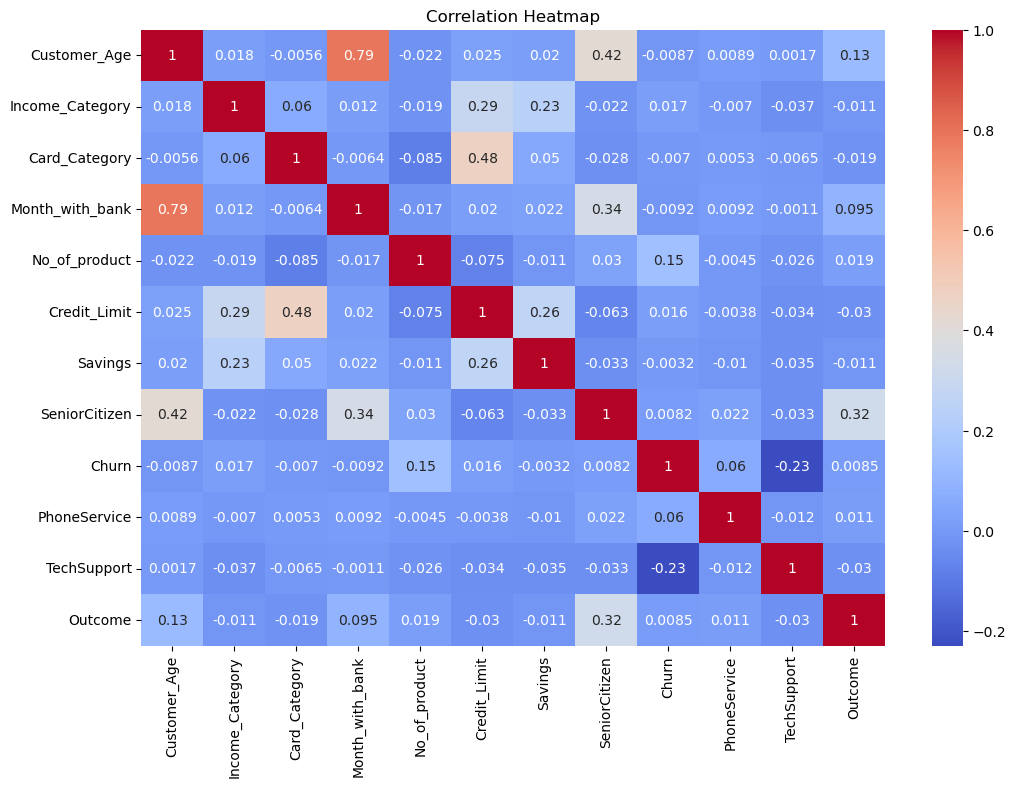

In [245]:
# Correlation Heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(ori_cols.corr(), annot=True, cmap='coolwarm')
plt.title("Correlation Heatmap")
plt.show()

Outcome does not have high correlation with most of the other variables. The highest positive correlations are for Senior Citizens, Customer Age.

The correlation matrix provided little information in understanding the key factors in campaign effectiveness due to the low correlations between outcome and the other factors.

In [253]:
X.head()

,Last_Contacted,Num_of_Contacts_Made,Months_Inactive_12_mon,Customer_Age,Total_Trans_Count,Total_Trans_Amt,Savings,Education_Level
0,-0.408415,-0.462696,1,-0.167598,42,1144,-0.434366,1
1,-0.408415,-0.462696,1,0.329839,33,1291,-0.330570,3
2,-0.408415,-0.243469,1,0.578557,20,1887,2.422477,3
4,-0.408415,-0.462696,1,-0.789394,28,816,-0.311055,0
5,-0.408415,0.852666,1,-0.291957,24,1088,-0.797503,3


In [265]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
X = ori[['Last_Contacted', 'Num_of_Contacts_Made', 'Months_Inactive_12_mon', 'Customer_Age', 
          'Total_Trans_Count', 'Total_Trans_Amt', 'Savings', 'Education_Level']]
y = ori['Outcome']

# Make sure y is categorical for classification
y = (y >= 1).astype(int)

# Removing NAs
mask = ~y.isnull()
X = X[mask]
y = y[mask]

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)

# Scale the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Fit the Random Forest model
rf_model = RandomForestClassifier(n_estimators=100, random_state=1, class_weight='balanced')
rf_model.fit(X_train_scaled, y_train)

RandomForestClassifier(class_weight='balanced', random_state=1)

In [267]:
# Importance
importances = rf_model.feature_importances_
impt = pd.DataFrame(importances, index=X.columns, columns=["Importance"]).sort_values("Importance", ascending = False)
impt

,Importance
Customer_Age,0.242485
Num_of_Contacts_Made,0.164985
Total_Trans_Amt,0.150884
Total_Trans_Count,0.134890
Savings,0.123936
Last_Contacted,0.083080
Education_Level,0.053484
Months_Inactive_12_mon,0.046257


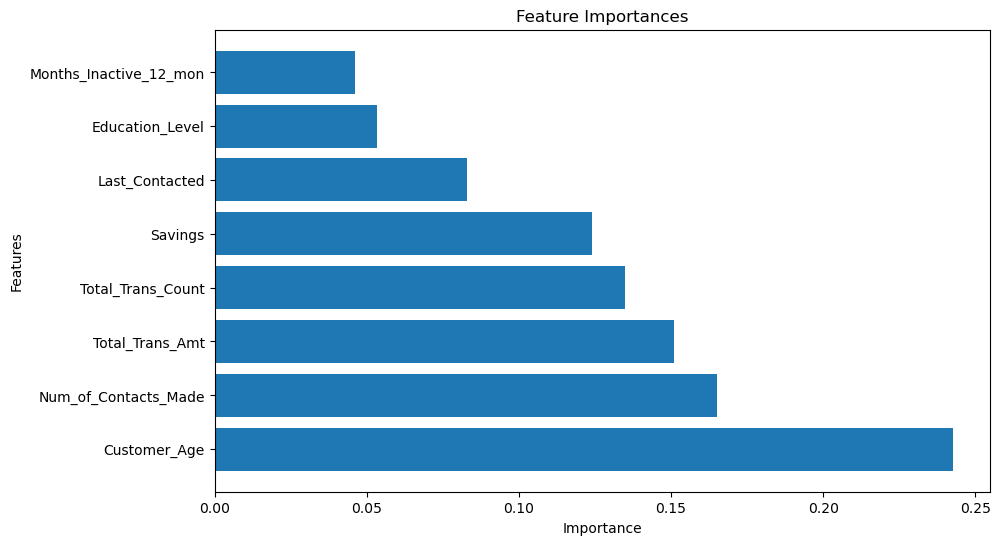

In [271]:
# Plotting the feature importances
plt.figure(figsize = (10, 6))
plt.title("Feature Importances")
plt.barh(impt.index, impt["Importance"], align="center")
plt.xlabel("Importance")
plt.ylabel("Features")
plt.show()

### Propose metrics for tracking campaign effectiveness over time

##### Key Factors Influencing Customer Engagement
1) Customer Segmentation:
    - Digital Engagement Level: Customers who are highly digitally engaged (Segment 1) are more likely to respond positively to digital marketing campaigns through channels like emails, social media, or mobile apps. Low-engagement customers (Segment 3) might prefer more traditional outreach like direct mail.
    - Transaction History: High spenders/frequent users (Segment 4) are likely to engage more with promotions related to exclusive offers, loyalty programs, or high-end products. On the other hand, low spenders (Segment 6) might be motivated by discounts or cost-saving opportunities.
    - Financial Status: Customers with high financial standing (Segment 10) might be drawn to campaigns promoting investment opportunities, premium accounts, or wealth management services. Low financial standing customers (Segment 12) may engage more with campaigns focused on debt management, credit improvement, or lower-cost products.

2) Personalization:
    - Personalization is crucial across all segments. The more tailored a campaign is to a customer’s habits, needs, and preferences, the higher the likelihood of engagement. For instance, using customer data to send offers relevant to their transaction behavior, product usage, or financial status can greatly increase engagement.

3) Communication Channel:
    - Digital engagement levels directly influence the preferred channels for communication. Highly digitally engaged customers are more responsive to email, social media, or app notifications, while others may prefer direct mail or phone calls. 


##### Proposed Metrics for Tracking Campaign Effectiveness
1) Engagement Rate:
    - Tracks the overall interaction with campaigns (e.g., email opens, clicks). This is a key indicator of initial interest across all customer segments.
2) Conversion Rate:
    - Measures the percentage of customers who complete the desired action (e.g., purchase, sign-up), giving direct insight into campaign success.
3) Customer Lifetime Value (CLV):
    - Helps track long-term profitability and how successful campaigns are in retaining and increasing the value of customers over time.
4) Return on Marketing Investment (ROMI):
    - Shows the financial impact of campaigns by comparing revenue generated to campaign costs, ensuring resources are allocated efficiently.